# PREVENDO O RISCO DE INADIMPLÊNCIA NO CRÉDITO RESIDENCIAL

### MODEL SELECTION AND TUNNING

#### Udacity - Engenheiro de Machine Learning
Vinicius Ferreira Santos - vyniciuss@gmail.com

## HOME CREDIT


### Importando as bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper import *
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)
# ================================================== #
#               Classifiers                          #
# ================================================== #
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
# ================================================== #
#               Validation and Test                  #
# ================================================== #
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
# ===================================================#
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from time import time
import warnings
warnings.filterwarnings("ignore")
path = "plots/"

C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.

C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.

C:\Users\vynic\Anaconda3\envs\py36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.



## CARREGANDO OS DADOS

In [2]:
#carregando os dados de treinamento
data_train = pd.read_csv("data/application_train_new.csv")

display(data_train.head(n=1))


,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,SK_ID_CURR,TARGET
0,0,-0.583687,0.783762,-0.464117,-0.098525,-0.47329,-0.055568,1.50688,0.894907,0.377004,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100002,1


**Tunning** é o processo de buscar os melhores hiperparâmetros para um determinado estimador. Para facilitar o trabalho, tal processo será executado com o auxílio do GridSearchCV que, como descrito na documentação do sklearn, realiza uma busca exaustiva sobre valores de parâmetros especificados para um estimador. Como podemos perceber, esse é um processo caro e lento de se realizar com computadores pessoais se a massa de dados for muito grande. Dessa forma, irei separar uma amostra de 16 mil linhas, onde 10 mil será para treino e 6 mil para teste, afim de facilitar o processo.


In [3]:
features = data_train.sample(n = 16000, random_state = 42)
labels = features['TARGET']
features = features.drop(columns = ['TARGET', 'SK_ID_CURR', 'Unnamed: 0'])
features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
245895,2.548310,0.855572,-0.295497,2.214159,-0.235201,-0.905926,0.627866,0.800316,1.242524,-0.869720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98194,-0.583687,1.501855,2.042883,1.908359,2.447259,-1.163509,0.288497,0.513517,0.962833,-1.028056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
36463,-0.583687,0.783762,-0.210865,1.094133,0.034632,1.519881,-0.428509,0.893393,0.704988,1.015737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
249923,-0.583687,1.501855,-0.899268,-0.078784,-0.917721,2.486791,-0.822415,0.233528,-1.784354,-0.108515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
158389,-0.583687,-0.652422,-0.746195,-0.830062,-0.885976,-0.051024,-0.983048,0.540759,-0.672487,1.656369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Separando em dados treino e teste

In [4]:
x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=6000,
                                                    random_state=42,
                                                    stratify=labels)

## Escolha e Afinamento de um Modelo

### Treinar uma variedade de classificadores

Como estou com um problema de natureza superviosionada e com classes desbalanceadas, usarei os seguintes algorítmos:

- Adaboost
- Gradient boosting

In [8]:
classifiers = ['adaboost', 'gradiend_boosting']

### Adaboost

Tempo de execução Adaboost: 2.336 s
Accuracy: 0.9194%
Score Roc: 79.307%
CV Score : Mean - 0.717786 | Std - 0.01726962 | Min - 0.6923086 | Max - 0.7465727


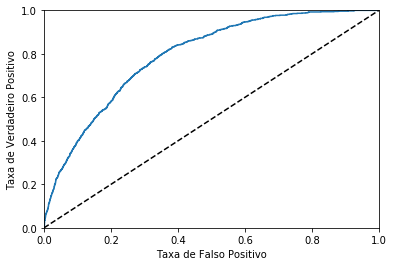

In [44]:
classifier = AdaBoostClassifier()
t0 = time()
classifier.fit(x_train, y_train)
print("Tempo de execução Adaboost:", round(time()-t0, 3), "s")
draw_roc_score(classifier, x_train, y_train)

### Gradient Boosting

Tempo de execução Gradient Boosting: 6.096 s
Accuracy: 0.9245%
Score Roc: 85.584%
CV Score : Mean - 0.727771 | Std - 0.008921915 | Min - 0.7153234 | Max - 0.7416834


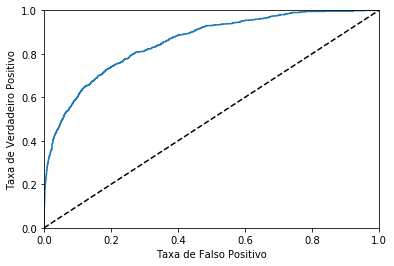

In [20]:
t0 = time()
gb = GradientBoostingClassifier()
gb.fit(x_train, y_train)
print("Tempo de execução Gradient Boosting:", round(time()-t0, 3), "s")
draw_roc_score(gb, x_train, y_train)

In [5]:
def draw_roc_score(classifier, x_train, y_train):
    y_probas = classifier.predict_proba(x_train)
    y_scores = y_probas[:, 1] 
    
    predictions = classifier.predict(x_train)
    cv_score = cross_validation.cross_val_score(classifier, x_train, y_train, cv=5, scoring='roc_auc')
    print("Accuracy: {}%".format(accuracy_score(y_train, predictions)))
    print("Score Roc: {}%".format(np.round(roc_auc_score(y_train, y_scores)*100, 3)))
    print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #draw roc curve
    fpr1, tpr1, thresholds = roc_curve(y_train, y_scores)
    plt.plot(fpr1, tpr1, linewidth=1.5, label=None)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.show()

In [6]:
def draw_feature_importance(feature_importances, columns):
    
    x, y = (list(x) for x in zip(*sorted(zip(feature_importances, columns), 
                                                            reverse = False)))
    draw_bar_plot_hor(x, y, 'Importância das features')

### Modelo Selecionado e Tuning

Como pudemos ver na seção anterior, o Gradient Boosting obteve o melhor desempenho utilizando uma instância padrão do classificador, ou seja, sem realizar qualquer ajuste nos seus hiperparâmetros. O proximo passo é identificar o melhor ajuste dos hiperparâmetros para o modelo selecionado, para isso, irei selecionar poucos hiperparâmetros a cada ajuste, afim de reduzir o tempo da busca e para tentar entender como está sendo a importância dada a cada feature. Nos passos a seguir, cada ajuste ideal encontrado será inserido como hiperparâmetro fixo na etapa seguinte.


Para iniciar, irei olhar a importância das features com o classificador padrão:

In [17]:
draw_feature_importance(gb.feature_importances_, x_train.columns)

### Passo 1

In [51]:
param1 = {'n_estimators': np.arange(10, 100, 10)} 
grid1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               min_samples_split=100,
                                                               min_samples_leaf=50,
                                                               max_depth=5,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
param_grid = param1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid1.fit(x_train, y_train)

display(grid1.grid_scores_, grid1.best_params_, grid1.best_score_)
draw_feature_importance(grid1.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.68768, std: 0.00839, params: {'n_estimators': 10},
 mean: 0.70333, std: 0.01258, params: {'n_estimators': 20},
 mean: 0.70740, std: 0.01106, params: {'n_estimators': 30},
 mean: 0.71668, std: 0.01087, params: {'n_estimators': 40},
 mean: 0.71789, std: 0.01181, params: {'n_estimators': 50},
 mean: 0.71792, std: 0.01264, params: {'n_estimators': 60},
 mean: 0.71656, std: 0.01174, params: {'n_estimators': 70},
 mean: 0.71995, std: 0.01038, params: {'n_estimators': 80},
 mean: 0.72076, std: 0.01042, params: {'n_estimators': 90}]

{'n_estimators': 90}

0.7207633871486057

Valor ideal para n_estimators é 90.

In [7]:
param2 = {'max_depth': np.arange(2, 10, 1), 'min_samples_split': np.arange(100, 1201, 100)} 
grid2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators = 90,
                                                                max_features = 'sqrt',
                                                                subsample = 0.8,
                                                                random_state = 10), 
param_grid = param2, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5) 
grid2.fit(x_train, y_train) 

display(grid2.grid_scores_, grid2.best_params_, grid2.best_score_)
draw_feature_importance(grid2.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.72336, std: 0.01489, params: {'max_depth': 2, 'min_samples_split': 100},
 mean: 0.72146, std: 0.01557, params: {'max_depth': 2, 'min_samples_split': 200},
 mean: 0.72218, std: 0.01550, params: {'max_depth': 2, 'min_samples_split': 300},
 mean: 0.72122, std: 0.01625, params: {'max_depth': 2, 'min_samples_split': 400},
 mean: 0.72170, std: 0.01654, params: {'max_depth': 2, 'min_samples_split': 500},
 mean: 0.72162, std: 0.01654, params: {'max_depth': 2, 'min_samples_split': 600},
 mean: 0.72101, std: 0.01544, params: {'max_depth': 2, 'min_samples_split': 700},
 mean: 0.72004, std: 0.01535, params: {'max_depth': 2, 'min_samples_split': 800},
 mean: 0.72164, std: 0.01591, params: {'max_depth': 2, 'min_samples_split': 900},
 mean: 0.72056, std: 0.01455, params: {'max_depth': 2, 'min_samples_split': 1000},
 mean: 0.72139, std: 0.01503, params: {'max_depth': 2, 'min_samples_split': 1100},
 mean: 0.72014, std: 0.01399, params: {'max_depth': 2, 'min_samples_split': 1200},
 mean: 0.7269

{'max_depth': 3, 'min_samples_split': 900}

0.7300935717269401

Valores ideais para max_depth é 3 e min_samples_split é 900

In [10]:
param3 = {'min_samples_leaf': np.arange(10,101, 5)} 
grid3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators = 90,
                                                                max_depth=3,
                                                                min_samples_split = 900,
                                                                max_features = 'sqrt',
                                                                subsample = 0.8,
                                                                random_state = 10), 
param_grid = param3, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5) 
grid3.fit(x_train, y_train) 

display(grid3.grid_scores_, grid3.best_params_, grid3.best_score_)
draw_feature_importance(grid3.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.72831, std: 0.00882, params: {'min_samples_leaf': 10},
 mean: 0.72870, std: 0.00944, params: {'min_samples_leaf': 15},
 mean: 0.72751, std: 0.01050, params: {'min_samples_leaf': 20},
 mean: 0.72735, std: 0.00974, params: {'min_samples_leaf': 25},
 mean: 0.72591, std: 0.00825, params: {'min_samples_leaf': 30},
 mean: 0.72957, std: 0.01081, params: {'min_samples_leaf': 35},
 mean: 0.72681, std: 0.01080, params: {'min_samples_leaf': 40},
 mean: 0.72928, std: 0.01053, params: {'min_samples_leaf': 45},
 mean: 0.72818, std: 0.01229, params: {'min_samples_leaf': 50},
 mean: 0.72750, std: 0.01381, params: {'min_samples_leaf': 55},
 mean: 0.72802, std: 0.01306, params: {'min_samples_leaf': 60},
 mean: 0.72842, std: 0.01288, params: {'min_samples_leaf': 65},
 mean: 0.72775, std: 0.01491, params: {'min_samples_leaf': 70},
 mean: 0.72829, std: 0.01260, params: {'min_samples_leaf': 75},
 mean: 0.72817, std: 0.01399, params: {'min_samples_leaf': 80},
 mean: 0.72839, std: 0.01357, params: {'

{'min_samples_leaf': 35}

0.7295729621436706

O valor ideal para min_samples_leaf foi 35, mas como a pontuação reduziu, irei rodar outro teste com um número elevado de min_samples_split, só que agora verificando o valor ideal junto com min_samples_leaf.

In [11]:
param3 = {'min_samples_leaf': np.arange(10,101, 5), 'min_samples_split': np.arange(100, 2201, 100)} 
grid3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators = 90,
                                                                max_depth=3,
                                                                max_features = 'sqrt',
                                                                subsample = 0.8,
                                                                random_state = 10), 
param_grid = param3, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5) 
grid3.fit(x_train, y_train) 

display(grid3.grid_scores_, grid3.best_params_, grid3.best_score_)
draw_feature_importance(grid3.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.72725, std: 0.01020, params: {'min_samples_leaf': 10, 'min_samples_split': 100},
 mean: 0.72560, std: 0.00928, params: {'min_samples_leaf': 10, 'min_samples_split': 200},
 mean: 0.72659, std: 0.00819, params: {'min_samples_leaf': 10, 'min_samples_split': 300},
 mean: 0.72824, std: 0.00972, params: {'min_samples_leaf': 10, 'min_samples_split': 400},
 mean: 0.72779, std: 0.01150, params: {'min_samples_leaf': 10, 'min_samples_split': 500},
 mean: 0.73042, std: 0.01092, params: {'min_samples_leaf': 10, 'min_samples_split': 600},
 mean: 0.73086, std: 0.01226, params: {'min_samples_leaf': 10, 'min_samples_split': 700},
 mean: 0.72993, std: 0.01094, params: {'min_samples_leaf': 10, 'min_samples_split': 800},
 mean: 0.72831, std: 0.00882, params: {'min_samples_leaf': 10, 'min_samples_split': 900},
 mean: 0.72926, std: 0.01137, params: {'min_samples_leaf': 10, 'min_samples_split': 1000},
 mean: 0.72977, std: 0.01007, params: {'min_samples_leaf': 10, 'min_samples_split': 1100},
 mean: 0

{'min_samples_leaf': 65, 'min_samples_split': 1800}

0.7318228562334101

O score voltou a subir e o valor ideal para min_samples_leaf ficou 65 e min_samples_split com 1800

In [13]:
param4 = {'max_features': np.arange(1, 30, 1)} 
grid4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.1,
                                                                n_estimators = 90,
                                                                max_depth=3,
                                                                max_features = 'sqrt',
                                                                subsample = 0.8,
                                                                min_samples_leaf= 65,
                                                                min_samples_split = 1800,
                                                                random_state = 10), 
param_grid = param4, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5) 
grid4.fit(x_train, y_train) 

display(grid4.grid_scores_, grid4.best_params_, grid4.best_score_)
draw_feature_importance(grid4.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.66965, std: 0.00771, params: {'max_features': 1},
 mean: 0.68708, std: 0.00765, params: {'max_features': 2},
 mean: 0.68499, std: 0.01168, params: {'max_features': 3},
 mean: 0.69639, std: 0.00847, params: {'max_features': 4},
 mean: 0.69813, std: 0.01332, params: {'max_features': 5},
 mean: 0.70830, std: 0.01230, params: {'max_features': 6},
 mean: 0.71396, std: 0.01065, params: {'max_features': 7},
 mean: 0.71697, std: 0.01156, params: {'max_features': 8},
 mean: 0.71879, std: 0.01121, params: {'max_features': 9},
 mean: 0.71795, std: 0.01270, params: {'max_features': 10},
 mean: 0.71459, std: 0.01091, params: {'max_features': 11},
 mean: 0.72541, std: 0.01126, params: {'max_features': 12},
 mean: 0.72177, std: 0.00914, params: {'max_features': 13},
 mean: 0.71916, std: 0.01143, params: {'max_features': 14},
 mean: 0.72516, std: 0.01260, params: {'max_features': 15},
 mean: 0.73182, std: 0.01395, params: {'max_features': 16},
 mean: 0.72772, std: 0.01217, params: {'max_featu

{'max_features': 16}

0.7318228562334101

O valor ideal para max_features é 16

In [22]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Accuracy: 0.9245%
Score Roc: 85.584%
CV Score : Mean - 0.7280987 | Std - 0.008790159 | Min - 0.7157041 | Max - 0.7420675


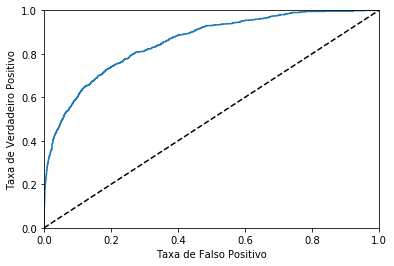

In [23]:
draw_roc_score(gb, x_train, y_train) 

In [19]:
grid4.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=16, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=65, min_samples_split=1800,
              min_weight_fraction_leaf=0.0, n_estimators=90,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)

Accuracy: 0.9195%
Score Roc: 79.911%
CV Score : Mean - 0.7318229 | Std - 0.01394504 | Min - 0.716533 | Max - 0.7545244


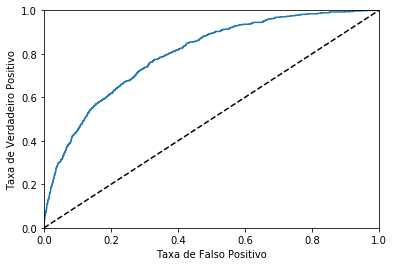

In [18]:
draw_roc_score(grid4.best_estimator_, x_train, y_train) 

In [26]:
param5 = {'max_features': np.arange(1, 30, 1)} 
grid5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate = 0.01,
                                                                n_estimators = 90,
                                                                max_depth=3,
                                                                max_features = 'sqrt',
                                                                subsample = 0.8,
                                                                min_samples_leaf= 65,
                                                                min_samples_split = 1800,
                                                                random_state = 10), 
param_grid = param5, scoring = 'roc_auc', n_jobs = 4, iid = False, cv = 5) 
grid5.fit(x_train, y_train) 

display(grid5.grid_scores_, grid5.best_params_, grid5.best_score_)
draw_feature_importance(grid5.best_estimator_.feature_importances_, x_train.columns)

[mean: 0.65686, std: 0.00583, params: {'max_features': 1},
 mean: 0.67253, std: 0.00550, params: {'max_features': 2},
 mean: 0.66047, std: 0.01525, params: {'max_features': 3},
 mean: 0.67016, std: 0.00783, params: {'max_features': 4},
 mean: 0.66961, std: 0.01049, params: {'max_features': 5},
 mean: 0.67874, std: 0.00923, params: {'max_features': 6},
 mean: 0.68316, std: 0.01259, params: {'max_features': 7},
 mean: 0.68363, std: 0.01026, params: {'max_features': 8},
 mean: 0.68577, std: 0.01174, params: {'max_features': 9},
 mean: 0.68937, std: 0.01196, params: {'max_features': 10},
 mean: 0.68777, std: 0.01274, params: {'max_features': 11},
 mean: 0.69172, std: 0.01283, params: {'max_features': 12},
 mean: 0.69288, std: 0.01432, params: {'max_features': 13},
 mean: 0.69500, std: 0.01023, params: {'max_features': 14},
 mean: 0.69697, std: 0.01484, params: {'max_features': 15},
 mean: 0.69960, std: 0.01414, params: {'max_features': 16},
 mean: 0.69799, std: 0.01676, params: {'max_featu

{'max_features': 27}

0.7069530333753571

Accuracy: 0.9186%
Score Roc: 74.443%
CV Score : Mean - 0.706953 | Std - 0.01434397 | Min - 0.6849591 | Max - 0.7258757


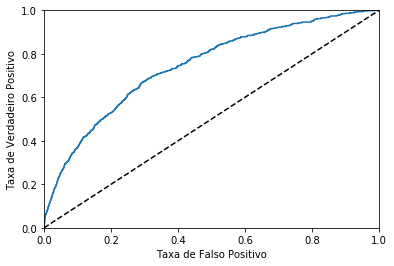

In [27]:
draw_roc_score(grid5.best_estimator_, x_train, y_train) 